# 1) Split data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
DATA_FOLDER = 'glove_data'

In [4]:
files_list = os.listdir(DATA_FOLDER)
files_list

['glove_train.csv', 'glove_test.csv', 'glove_val.csv']

In [5]:
dfs = []
for file in files_list:
    df = pd.read_csv(os.path.join(DATA_FOLDER, file), header=0, delimiter=",")
    print("File: ", file)
    print("Shape: ", df.shape)
    print(f'There are {df.isna().any(axis=1).sum()} nan rows')
    dfs.append(df)
dfs[0].head()

File:  glove_train.csv
Shape:  (101336, 8)
There are 0 nan rows
File:  glove_test.csv
Shape:  (23294, 8)
There are 0 nan rows
File:  glove_val.csv
Shape:  (13763, 8)
There are 0 nan rows


,Count,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Activity
0,1,912,334,365,-183,-112,-65,0
1,2,852,358,358,-181,-146,-51,0
2,3,746,371,399,-154,-109,-24,0
3,4,741,359,416,-153,-55,-13,0
4,5,721,402,368,-189,-78,-20,0


In [15]:
train_data = dfs[0]
val_data = dfs[2]
test_data = dfs[1]

import numpy as np
train_idx = []
val_idx = []
test_idx = []

def gen_idx(idx, data):
    for i in range(data.shape[0] - 1):
        if (data.iloc[i]['Count'] - data.iloc[i + 1]['Count'] > 0):
            idx.append(i)
gen_idx(train_idx, train_data)
gen_idx(val_idx, val_data)
gen_idx(test_idx, test_data)

In [16]:
train_idx = [-1] + train_idx
val_idx = [-1] + val_idx
test_idx = [-1] + test_idx

# 3) Data Preprocessing

In [17]:
train_data = train_data.drop(columns=['Count'])
val_data = val_data.drop(columns=['Count'])
test_data = test_data.drop(columns=['Count'])

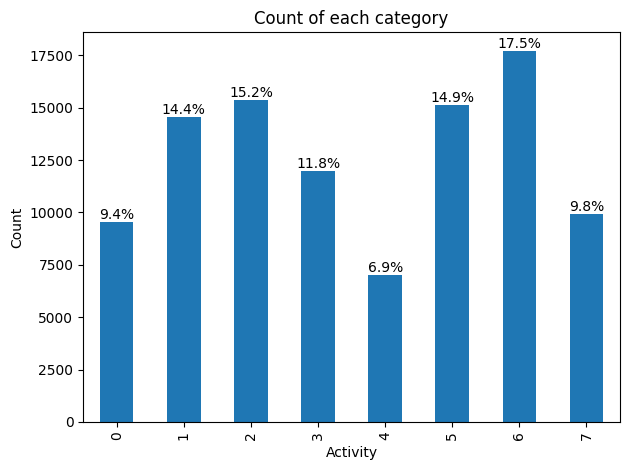

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick


def plot_categories_count(y):
    count = y.value_counts().sort_index()
    ax = count.plot(kind='bar')
    plt.title('Count of each category')
    plt.xlabel('Activity')
    plt.ylabel('Count')

    # Reference: https://stackoverflow.com/questions/73674585/pandas-matplotlib-labels-bars-as-percentage
    percentage = count / count.sum() * 100
    labels = [f'{p:.1f}%' for p in percentage]
    for container in ax.containers:
        ax.bar_label(container, labels=labels)
    plt.tight_layout()
    plt.show()

plot_categories_count(train_data['Activity'])

In [19]:
train_data = train_data.to_numpy()
val_data = val_data.to_numpy()
test_data = test_data.to_numpy()

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class customDataset(Dataset):
    def __init__(self, data, idx):
        self.data = data
        self.idx = idx
    def __len__(self):
        return len(self.idx) - 1
    def __getitem__(self, idx):
        return self.data[self.idx[idx] + 1:self.idx[idx + 1] + 1]

train_dataset = customDataset(train_data, train_idx)
val_dataset = customDataset(val_data, val_idx)
test_dataset = customDataset(test_data, test_idx)

def collate_fn(batch):
    # Convert each item in the batch to a tensor
    batch = [torch.tensor(i) for i in batch]
    batch.append(torch.zeros(60,7))

    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
    num_elements = len(batch)

    batch = batch[:num_elements - 1]
    batch = batch.permute(0, 2, 1)

    return batch
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

# 4) Training and tuning

In [21]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
!pip install optuna

In [23]:
from models import CNN
from engine import train, evaluate
import time
import math
import os
import optuna
from copy import deepcopy

OUTPUT_PATH = "/content/"
DB = "tuning_db"
hyperparams = {
    "num_trials": 20,
    "dropout_rate": (0.3, 0.6),
    "num_epochs": (100, 300),
}

NUM_CLASSES = 8

def objective(trial):
    dropout_range = hyperparams["dropout_rate"]
    dropout_rate = trial.suggest_float("dropout", *dropout_range)
    epochs_range = hyperparams["num_epochs"]
    epochs = trial.suggest_int("epochs", *epochs_range)

    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = CNN(NUM_CLASSES, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, criterion, optimizer, device, num_epochs=epochs)
    results = evaluate(model, val_loader, device)
    return results[2]

sampler = optuna.samplers.QMCSampler(seed = 42)
db_folder = f"{OUTPUT_PATH}/{DB}"
# Create folder if it doesn't exist
if not os.path.exists(db_folder):
    os.makedirs(db_folder)
storage = f"sqlite:///{db_folder}/random.db"
study = optuna.create_study(direction="maximize", sampler=sampler,
                            storage=storage, study_name="random", load_if_exists=True)
study.optimize(objective, n_trials=hyperparams["num_trials"])
trial = study.best_trial
best_params_random = trial.params
print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

<ipython-input-23-5eff104644dd>:37: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = optuna.samplers.QMCSampler(seed = 42)
[I 2024-11-16 18:55:18,786] A new study created in RDB with name: random
[I 2024-11-16 18:55:51,044] Trial 0 finished with value: 100.0 and parameters: {'dropout': 0.4123620356542087, 'epochs': 291}. Best is trial 0 with value: 100.0.


Loss: 0.03035656392967212
Accuracy: 100.00%


[I 2024-11-16 18:55:58,944] Trial 1 finished with value: 100.0 and parameters: {'dropout': 0.3, 'epochs': 100}. Best is trial 0 with value: 100.0.


Loss: 0.07358683297752577
Accuracy: 100.00%


[I 2024-11-16 18:56:13,931] Trial 2 finished with value: 100.0 and parameters: {'dropout': 0.44999999999999996, 'epochs': 200}. Best is trial 0 with value: 100.0.


Loss: 0.11252406917628832
Accuracy: 100.00%


[I 2024-11-16 18:56:25,447] Trial 3 finished with value: 99.57081545064378 and parameters: {'dropout': 0.5249999999999999, 'epochs': 150}. Best is trial 0 with value: 100.0.


Loss: 0.3157139014219865
Accuracy: 99.57%


[I 2024-11-16 18:56:44,604] Trial 4 finished with value: 100.0 and parameters: {'dropout': 0.375, 'epochs': 250}. Best is trial 0 with value: 100.0.


Loss: 0.03921748985158047
Accuracy: 100.00%


[I 2024-11-16 18:56:57,839] Trial 5 finished with value: 99.57081545064378 and parameters: {'dropout': 0.4125, 'epochs': 175}. Best is trial 0 with value: 100.0.


Loss: 0.06820788151526358
Accuracy: 99.57%


[I 2024-11-16 18:57:18,344] Trial 6 finished with value: 98.71244635193133 and parameters: {'dropout': 0.5625, 'epochs': 275}. Best is trial 0 with value: 100.0.


Loss: 0.15532894539865083
Accuracy: 98.71%


[I 2024-11-16 18:57:29,008] Trial 7 finished with value: 99.57081545064378 and parameters: {'dropout': 0.4875, 'epochs': 125}. Best is trial 0 with value: 100.0.


Loss: 0.21189357107505202
Accuracy: 99.57%


[I 2024-11-16 18:57:46,255] Trial 8 finished with value: 100.0 and parameters: {'dropout': 0.33749999999999997, 'epochs': 225}. Best is trial 0 with value: 100.0.


Loss: 0.1309135158517165
Accuracy: 100.00%


[I 2024-11-16 18:57:58,394] Trial 9 finished with value: 99.57081545064378 and parameters: {'dropout': 0.35624999999999996, 'epochs': 162}. Best is trial 0 with value: 100.0.


Loss: 0.02093999095086474
Accuracy: 99.57%


[I 2024-11-16 18:58:17,797] Trial 10 finished with value: 99.57081545064378 and parameters: {'dropout': 0.50625, 'epochs': 263}. Best is trial 0 with value: 100.0.


Loss: 0.031621655107301194
Accuracy: 99.57%


[I 2024-11-16 18:58:26,435] Trial 11 finished with value: 99.57081545064378 and parameters: {'dropout': 0.58125, 'epochs': 112}. Best is trial 0 with value: 100.0.


Loss: 0.4071778077632189
Accuracy: 99.57%


[I 2024-11-16 18:58:42,255] Trial 12 finished with value: 98.28326180257511 and parameters: {'dropout': 0.43125, 'epochs': 213}. Best is trial 0 with value: 100.0.


Loss: 0.3821163970278576
Accuracy: 98.28%


[I 2024-11-16 18:58:52,723] Trial 13 finished with value: 100.0 and parameters: {'dropout': 0.39375, 'epochs': 137}. Best is trial 0 with value: 100.0.


Loss: 0.18319300591247156
Accuracy: 100.00%


[I 2024-11-16 18:59:10,276] Trial 14 finished with value: 99.57081545064378 and parameters: {'dropout': 0.54375, 'epochs': 238}. Best is trial 0 with value: 100.0.


Loss: 0.08967928565107286
Accuracy: 99.57%


[I 2024-11-16 18:59:24,548] Trial 15 finished with value: 99.57081545064378 and parameters: {'dropout': 0.46875, 'epochs': 187}. Best is trial 0 with value: 100.0.


Loss: 0.5637238374911249
Accuracy: 99.57%


[I 2024-11-16 18:59:46,094] Trial 16 finished with value: 100.0 and parameters: {'dropout': 0.31875, 'epochs': 288}. Best is trial 0 with value: 100.0.


Loss: 0.012405025441239559
Accuracy: 100.00%


[I 2024-11-16 19:00:00,615] Trial 17 finished with value: 100.0 and parameters: {'dropout': 0.328125, 'epochs': 194}. Best is trial 0 with value: 100.0.


Loss: 0.21142694071750157
Accuracy: 100.00%


[I 2024-11-16 19:00:22,786] Trial 18 finished with value: 99.57081545064378 and parameters: {'dropout': 0.478125, 'epochs': 294}. Best is trial 0 with value: 100.0.


Loss: 0.05157518524856641
Accuracy: 99.57%


[I 2024-11-16 19:00:33,592] Trial 19 finished with value: 98.28326180257511 and parameters: {'dropout': 0.553125, 'epochs': 143}. Best is trial 0 with value: 100.0.


Loss: 0.32325203088112175
Accuracy: 98.28%
Accuracy: 100.0
Best hyperparameters: {'dropout': 0.4123620356542087, 'epochs': 291}


# 5) Final test

In [24]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
model = CNN(NUM_CLASSES, 0.45).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer, device, num_epochs=200)

Loss: 0.11252406917628832


Accuracy: 96.19%


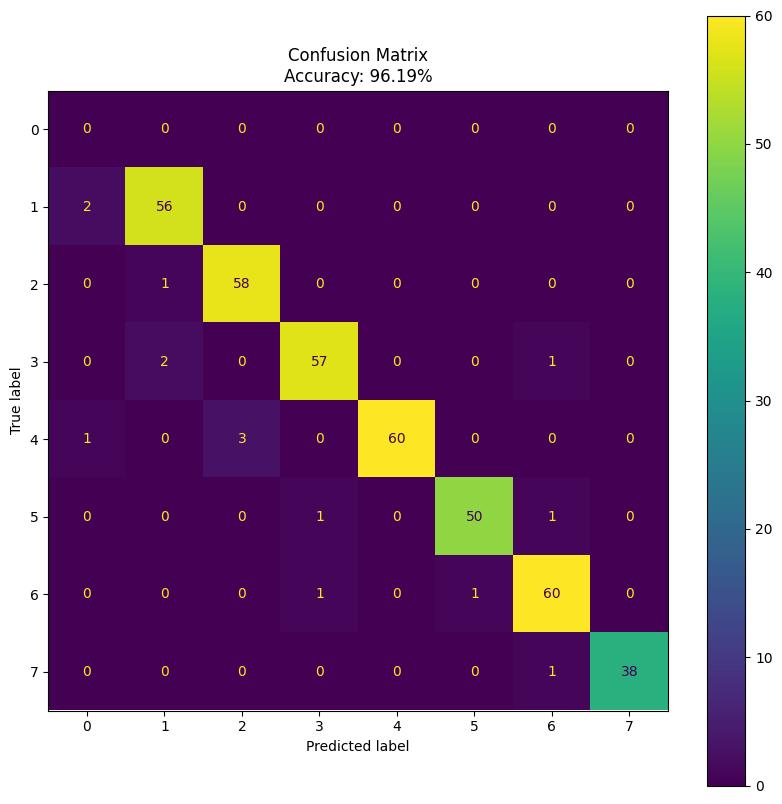

In [25]:
from engine import evaluate, plot_confusion_matrix
y, y_pred, acc = evaluate(model, test_loader, device)
plot_confusion_matrix(y, y_pred, acc)


In [26]:
torch.save(model.state_dict(), "model.pth")

In [27]:
# Save parameters to txt file to copy to hls
# iterate through all layers
params = {}
for name, layer in model.named_children():
    if isinstance(layer, nn.Conv1d):
        params[name] = torch.flatten(layer.weight.data.permute(0, 2, 1), start_dim=1, end_dim=2)
        # concat weight with bias
        params[name] = torch.cat((params[name], layer.bias.data.unsqueeze(1)), 1)
    elif isinstance(layer, nn.Linear):
        params[name] = torch.cat((layer.weight.data, layer.bias.data.unsqueeze(1)), 1)

# convert params to c++ array and save to txt file
text = ""
for key, value in params.items():
    converted_str = str(value.cpu().numpy().tolist()).replace('[', '{').replace(']', '}')
    if (value.dim() == 1):
        text += f"float {key}[{value.shape[0]}] = {converted_str};\n"
    else:
        text += f"float {key}[{value.shape[0]}][{value.shape[1]}] = {converted_str};\n"

with open('params.txt', 'w') as f:
    f.write(text)
